In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import datetime
from __future__ import division

from moztelemetry import get_pings, get_pings_properties, get_one_ping_per_client

%pylab inline

Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# We grab pings starting from 2 days ago until [TimeWindow] days ago.
TimeWindow = 14

# Additional filters.
Filters = {
    'app': 'Firefox',
    
    # We sample 0.5% of pings. For testing, it is beter to use a small number
    # here (like 0.001) to speed up processing time.
    'fraction': 0.001,
    
    # Optionally restrict pings to a single channel.
    # 'channel': 'beta',
}

# In case you need them!
VendorIDs = {
    'Intel': '0x8086',
    'NVIDIA': '0x10de',
    'AMD': '0x1002',
    'ATI': '0x1002'
}

In [3]:
###############################
# This section gathers pings. #
###############################

def run_get_pings():
    def fmt_date(d):
        return d.strftime("%Y%m%d")
    t1 = fmt_date(datetime.datetime.now() - datetime.timedelta(TimeWindow + 2)) # go back 16 days
    t2 = fmt_date(datetime.datetime.now() - datetime.timedelta(2)) # go back 2 days
    return get_pings(sc, build_id=(t1, t2), **Filters)

# Get pings for the parameters in the previous step.
raw_pings = run_get_pings()

In [81]:
######################################################################
# This section takes the raw ping list, then formats and filters it. #
######################################################################

# Map the pings into a more readable dictionary-like form. To see
# what these look like, execute "pings.take(1)".
unique_pings = get_pings_properties(raw_pings, [
  "clientId",
  "environment/build/version",
  "environment/system/os/name",
  "environment/system/os/version",
  "environment/system/os/servicePackMajor",
  "environment/system/os/servicePackMinor",
  "environment/system/gfx/adapters",
  "payload/histograms/DEVICE_RESET_REASON"
])
unique_pings = get_one_ping_per_client(unique_pings)

In [82]:
# We add two extra steps. The first rewrites the ping to have some
# information more easily accessible (like the primary adapter),
# and the second step removes any pings that don't have adapter
# information.
def rewrite_ping(p):
    adapters = p.get('environment/system/gfx/adapters', None)
    if not adapters:
        return None
    adapter = adapters[0]
            
    p['adapter'] = adapter
            
    # Convert the version to a tuple of integers.
    if 'driverVersion' in adapter:
        p['driverVersion'] = [int(n) for n in adapter['driverVersion'].split('.') if n.isdigit()]
    return p

def filter_ping(p):
    return 'adapter' in p
pings = unique_pings.cache()
pings = pings.map(rewrite_ping).filter(filter_ping)
#pings = pings.cache()

In [83]:
# Observe the format of a random ping. This may take some time since it has to
# execute the pipeline.
#pings.take(1)
#pings.take(1)
#new_pings = pings.map(rewrite_ping).filter(filter_ping)
pings.take(1)

[{'adapter': {u'GPUActive': True,
   u'description': u'Intel(R) HD Graphics',
   u'deviceID': u'0x0046',
   u'driver': u'igdumdx32 igd10umd32',
   u'driverDate': u'3-26-2011',
   u'driverVersion': u'8.15.10.2345',
   u'subsysID': u'1425103c',
   u'vendorID': u'0x8086'},
  'clientId': u'1b760353-2448-4c8b-b3ec-1592901d32e2',
  'driverVersion': [8, 15, 10, 2345],
  'environment/build/version': u'46.0',
  'environment/system/gfx/adapters': [{u'GPUActive': True,
    u'description': u'Intel(R) HD Graphics',
    u'deviceID': u'0x0046',
    u'driver': u'igdumdx32 igd10umd32',
    u'driverDate': u'3-26-2011',
    u'driverVersion': u'8.15.10.2345',
    u'subsysID': u'1425103c',
    u'vendorID': u'0x8086'}],
  'environment/system/os/name': u'Windows_NT',
  'environment/system/os/servicePackMajor': 0,
  'environment/system/os/servicePackMinor': 0,
  'environment/system/os/version': u'6.1',
  'payload/histograms/CANVAS_WEBGL_SUCCESS': None}]

In [8]:
# Count the total number of sessions in the dataset.
TotalSessions = pings.count()
print('Number of sessions: {0}'.format(TotalSessions))

Number of sessions: 57228


In [9]:
##############################################
# Helper function to compare version tuples. #
##############################################
def compare_version_tuples(v1, v2):
    n = max(len(v1), len(v2))
    for i in xrange(0, n):
        x1 = v1[i] if i < len(v1) else 0
        x2 = v2[i] if i < len(v2) else 0
        if x1 != x2:
            return x1 - x2
    return 0

# Tests
assert(compare_version_tuples((1, 0), (1, 1)) < 0)
assert(compare_version_tuples((1, 1), (1, 0)) > 0)
assert(compare_version_tuples((1, 1), (1, 1)) == 0)
assert(compare_version_tuples((1,), (1, 0)) == 0)
assert(compare_version_tuples((1,), (1, 0)) == 0)
assert(compare_version_tuples((1,0), (2,5)) < 0)

In [30]:
import json
import urllib2

gpu_db = json.load(urllib2.urlopen('https://raw.githubusercontent.com/jrmuizel/gpu-db/master/intel.json'))
devices = {}
for gen in gpu_db['8086'].items():
    for chipset in gen[1].items():
        for dev in chipset[1]:
            #print dev, gen[0]
            devices[int(dev,16)] = gen[0]
'gen5' in [devices[int('0x0046',16)]]

True

OK                21
Hung               3
Removed           16
Reset            437
Driver error       0
Invalid Call      15
Out of memory      8
dtype: float64


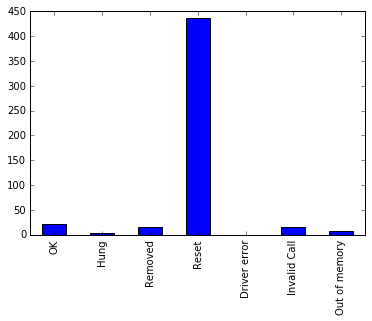

In [80]:
# Sample filter #1 - how many people are using Intel devices
# with a driver less than 8.15.10.2622? (bug 1175366).
BadVersion = (8, 15, 10, 2622)
def sample_filter_1(p):
    if not 'vendorID' in p['adapter']:
        return False
    if p['adapter']['vendorID'] != VendorIDs['Intel']:
        return False
    if p['payload/histograms/DEVICE_RESET_REASON'] is None:
        return False
    if devices[int(p['adapter']['deviceID'],16)] in ('gen4', 'gen5', 'gen6','gen7','gen8','gen9'):
    #if devices[int(p['adapter']['deviceID'],16)] in ('gen7'):

        return True
    return False

sample_result_1 = pings.filter(sample_filter_1)
DeviceResetReason = [
  "OK",
  "Hung",
  "Removed",
  "Reset",
  "Driver error",
  "Invalid Call",
  "Out of memory",
]
TDRResults = sample_result_1.map(lambda p: p[DeviceResetReasonKey]).reduce(lambda x, y: x + y)
#help(pd.Series(TDRResults.values, DeviceResetReason))
print(pd.Series(TDRResults.values[1:8],DeviceResetReason))
pd.Series(TDRResults.values[1:8],DeviceResetReason).plot.bar()
#reduce(lambda x, y: sample_result_1.take(2))
#sample_result_1.take(1)[0]['payload/histograms/DEVICE_RESET_REASON'])
#print('{0} out of {1} sessions matched. ({2:.2f}%)'.format(
#    sample_result_1.count(),
#    pings.count(),
#   ((sample_result_1.count() / pings.count()) * 100)))